In [1]:
import math
import h5py
import numpy as np
import netCDF4 as nc
#from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.1.0a0+29c30b1


# CNN

### Prepare Data for CNN in PyTorch

In [2]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 59kB 0 366 731 1096 1461 ... 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 2GB ...

In [3]:
PRECT = pd.read_csv('Detrended_PRECT_reordered.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head()

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542

In [4]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [5]:
y = y.reshape(-1, 3)
y = y[:, 0]
y.shape

(7400,)

In [6]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [7]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [8]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [9]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [10]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)#49
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
#BATCH_SIZE = 16
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 1])
torch.Size([10, 74, 1])
torch.Size([10, 74, 1])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [11]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Build CNN

In [45]:
class Net(nn.Module):
    def __init__(self, p, p2d):
        super(Net, self).__init__()
        self.p = p
        self.p2d = p2d
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1, bias = False)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1, bias = False)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1, bias = False)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p2d)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1, 0.1)
model

#R2 0.143. p = 0.2, lr = 0.0001, no batchnorm, same P for both, weights saved 
# test and valid mse around 19.3-4

# Doing hyperparam tuning on this one

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [46]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12769

### Train CNN

In [47]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

#### Hyperparameter Tuning

In [48]:
# Hyperparameter Tuning Loop

tuning_valid_losses = []

for lr in [0.001, 0.0001, 0.00001]:
        for p in [0.1, 0.2, 0.3, 0.4, 0.5]:
            for p2 in [0.1, 0.2]:
        
                model = Net(p, p2)
                model.to(device)
                valid_losses = []

                loss_fn = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # 5 epochs didn't give any of them enough to learn anything. Maybe do 10-20?
                epochs = 10
                print(f"Learning Rate: {lr}\nDropout Probability: {p}\nConv Dropout Probability: {p2}")
                for t in range(epochs):

                    print(f"Epoch {t+1}\n-------------------------------")
                    train_loop(dataloader_train, model, loss_fn, optimizer)
                    test_valid_loop(dataloader_valid, model, loss_fn)

                # Should we pick the best validation loss or just the most recent?

                # Most Recent:
                # tuning_valid_losses.append((valid_losses[epochs -1 ], lr, p))

                # Best:
                best_valid_loss = min(valid_losses)

                tuning_valid_losses.append((best_valid_loss, lr, p, p2))
            
print("Done!\n")



Learning Rate: 0.001
Dropout Probability: 0.1
Conv Dropout Probability: 0.1
Epoch 1
-------------------------------
loss: 16.766443  [   32/ 5920]
loss: 16.155682  [ 1184/ 5920]
loss: 14.212112  [ 2336/ 5920]
loss: 19.044895  [ 3488/ 5920]
loss: 20.030546  [ 4640/ 5920]
loss: 9.525753  [ 5792/ 5920]
Validation Loss: 20.234165 

Epoch 2
-------------------------------
loss: 19.366825  [   32/ 5920]
loss: 18.196884  [ 1184/ 5920]
loss: 18.547831  [ 2336/ 5920]
loss: 16.198437  [ 3488/ 5920]
loss: 23.167927  [ 4640/ 5920]
loss: 23.721684  [ 5792/ 5920]
Validation Loss: 20.184916 

Epoch 3
-------------------------------
loss: 8.594472  [   32/ 5920]
loss: 19.057426  [ 1184/ 5920]
loss: 21.009087  [ 2336/ 5920]
loss: 26.264084  [ 3488/ 5920]
loss: 18.498693  [ 4640/ 5920]
loss: 13.316195  [ 5792/ 5920]
Validation Loss: 19.613947 

Epoch 4
-------------------------------
loss: 15.763689  [   32/ 5920]
loss: 17.354191  [ 1184/ 5920]
loss: 19.864244  [ 2336/ 5920]
loss: 19.459660  [ 3488/ 592

In [49]:
# Pull out best lr and p from above

best_loss = np.inf
for loss, lr, p, p2 in tuning_valid_losses:
    if loss < best_loss:
        best_loss = loss
        tuned_lr = lr
        tuned_p = p
        tuned_p2 = p2

print(f"Optimal Learning Rate: {tuned_lr}\nOptimal Dropout Probability: {tuned_p}")

Optimal Learning Rate: 0.001
Optimal Dropout Probability: 0.4


#### Training with best lr and p

In [50]:
# Train model and evaluate on validation set for each epoch

# Optimal values from performance:
# tuned_p = 0.5
# tuned_p2 = 0.1
# tuned_lr = 0.0001


model = Net(tuned_p, tuned_p2)
model.to(device)
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 500

best_loss = np.inf
patience = 30
no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):
    
    if no_improvement_counter >= patience:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 12.613791  [   32/ 5920]
loss: 21.411816  [ 1184/ 5920]
loss: 37.832279  [ 2336/ 5920]
loss: 26.954977  [ 3488/ 5920]
loss: 14.130157  [ 4640/ 5920]
loss: 16.819344  [ 5792/ 5920]
Validation Loss: 20.764685 

Epoch 2
-------------------------------
loss: 16.727566  [   32/ 5920]
loss: 13.246941  [ 1184/ 5920]
loss: 26.279327  [ 2336/ 5920]
loss: 19.662611  [ 3488/ 5920]
loss: 19.996616  [ 4640/ 5920]
loss: 17.462191  [ 5792/ 5920]
Validation Loss: 20.327762 

Epoch 3
-------------------------------
loss: 13.090057  [   32/ 5920]
loss: 17.761879  [ 1184/ 5920]
loss: 39.345291  [ 2336/ 5920]
loss: 14.692678  [ 3488/ 5920]
loss: 18.483112  [ 4640/ 5920]
loss: 19.089920  [ 5792/ 5920]
Validation Loss: 20.256532 

Epoch 4
-------------------------------
loss: 18.716663  [   32/ 5920]
loss: 18.617558  [ 1184/ 5920]
loss: 18.201828  [ 2336/ 5920]
loss: 16.729404  [ 3488/ 5920]
loss: 15.463526  [ 4640/ 5920]
loss: 35.616684  [ 5792/ 5920]
Validatio

### Evaluate CNN

In [51]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2


actual_values = np.array(y_test.squeeze(1))

# Instantiate model
model_best_weights = Net(tuned_p, tuned_p)
model_best_weights.to(device)

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

#model_best_weights.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

X_test.to(device)
# Set the model to evaluation mode
model_best_weights.eval()
model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

#torch.save(model_best_weights.state_dict(), 'avg_pool_no_bias_best_weights_1472.pth')

R-squared: 0.12937015295028687


0.1459: avg pool, no bias, 0.1/0.5 dropout probs. LR = 0.00005
0.1472: avg pool, no bias, 0.1/0.5 dropout probs. LR = 0.0001

In [52]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)
test_valid_loop(dataloader_test, model, loss_fn, valid = False)

Test Loss: 19.733728 

Test Loss: 21.782737 



In [53]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


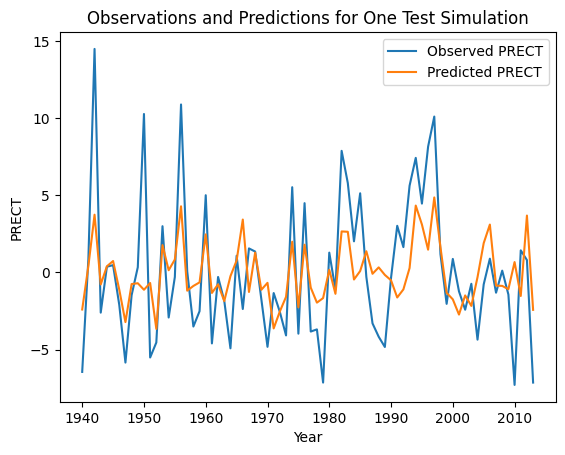

In [54]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

In [55]:
train_loss_dict = dict()

valid_loss_dict = dict()

for i in range(len(train_losses)):
    train_loss_dict[i+1] = train_losses[i]
    valid_loss_dict[i+1] = valid_losses[i]

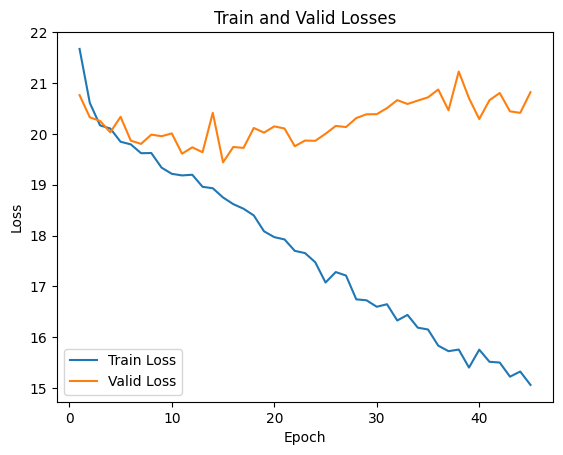

In [56]:
train_loss_df = pd.DataFrame(list(train_loss_dict.items()), columns=['Epoch', 'Train Loss'])
valid_loss_df = pd.DataFrame(list(valid_loss_dict.items()), columns=['Epoch', 'Valid Loss'])

# Merge the DataFrames on 'Epoch' column
merged_df = pd.merge(train_loss_df, valid_loss_df, on='Epoch')

# Plot the losses
plt.plot(merged_df['Epoch'], merged_df['Train Loss'], label='Train Loss')
plt.plot(merged_df['Epoch'], merged_df['Valid Loss'], label='Valid Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

https://arxiv.org/pdf/1904.03392.pdf
- see figure 3b

# XAI

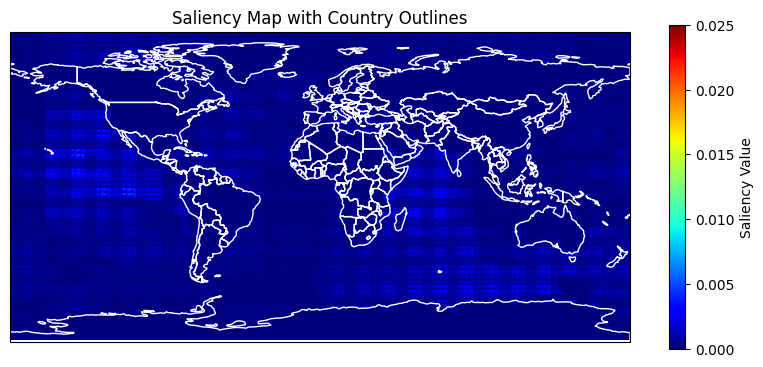

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import torch
import numpy as np
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from captum.attr import Saliency
from captum.attr import visualization as viz
from PIL import Image

# model_best_weights = Net(0.1,0.1)
# model_best_weights.to(device)
# model_best_weights.load_state_dict(torch.load('avg_pool_no_bias_best_weights_1472.pth', map_location=device))

longitude = ds2['lon'].values
latitude = ds2['lat'].values
# Generate a sample input tensor
input_data = X_test[98].unsqueeze(0).unsqueeze(0)  # Example input data
input_data.requires_grad_(True)

# Create a Saliency object for your model
saliency = Saliency(model_best_weights)

# Compute the saliency map
saliency_map = saliency.attribute(input_data.to(device))

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.flipud(saliency_map_np.squeeze())

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines and fill them in white
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Saliency Value')
img.set_clim(0, 0.025)

plt.title('Saliency Map with Country Outlines')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import torch
import numpy as np
from captum.attr import GuidedGradCam
from PIL import Image

# Generate a sample input tensor
input_data = X_test[109].unsqueeze(0).unsqueeze(0)  # Example input data
input_data.requires_grad_(True)
# Create a GuidedGradCam object for your model
guided_gradcam = GuidedGradCam(model_best_weights, model_best_weights.conv3)  # Example target layer

# Compute the saliency map
saliency_map = guided_gradcam.attribute(input_data.to(device), 0)

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.mean(np.abs(saliency_map_np), axis=0)
# Flip the saliency map array to match the coordinate system expected by cartopy
saliency_map_np = np.flipud(saliency_map_np)

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('GuidedGradCam Value')

plt.title('GuidedGradCam Map')
plt.show()


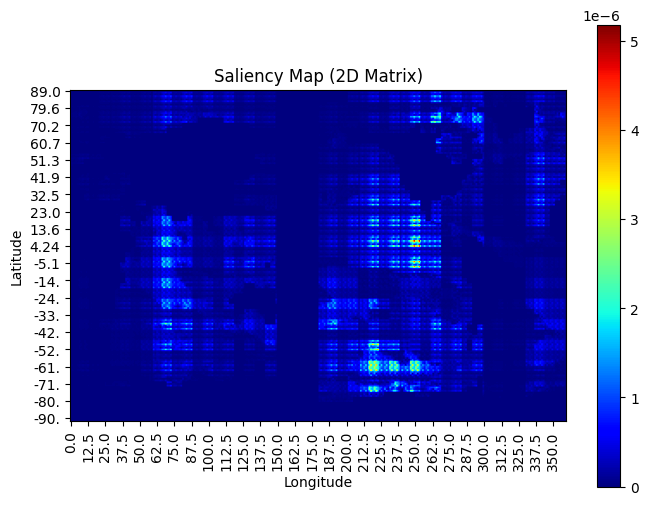

In [37]:
# View saliency_map_np as a 2D matrix
# Reorder the saliency map array to match the coordinate system expected by cartopy
#saliency_map_np = np.flipud(saliency_map_np.squeeze())

plt.figure(figsize=(8, 6))
plt.imshow(saliency_map_np, cmap='jet')

# Set x-axis ticks and labels using longitude values, displaying every 10th tick
plt.xticks(np.arange(0, len(ds2['lon']), 10), ds2['lon'].values[::10], rotation='vertical')
plt.xlabel('Longitude')

# Set y-axis ticks and labels using latitude values, displaying every 10th tick
plt.yticks(np.arange(0, len(ds2['lat']), 10), [str(i)[:4] for i in ds2['lat'].values[::10][::-1]])
plt.ylabel('Latitude')

plt.colorbar()
plt.title('Saliency Map (2D Matrix)')
plt.show()


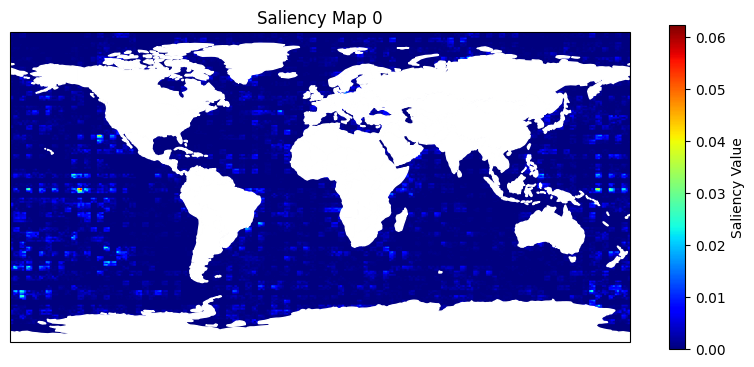

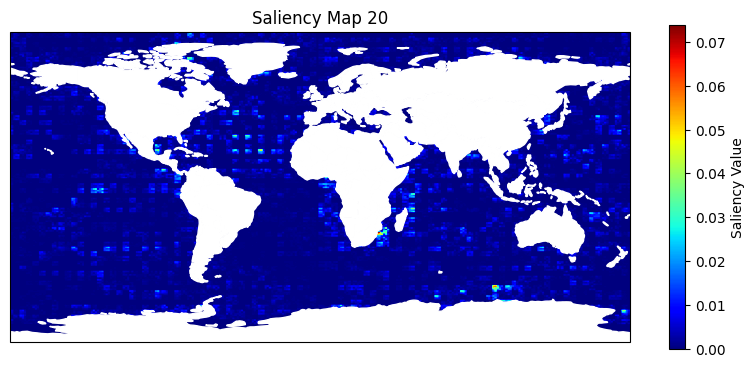

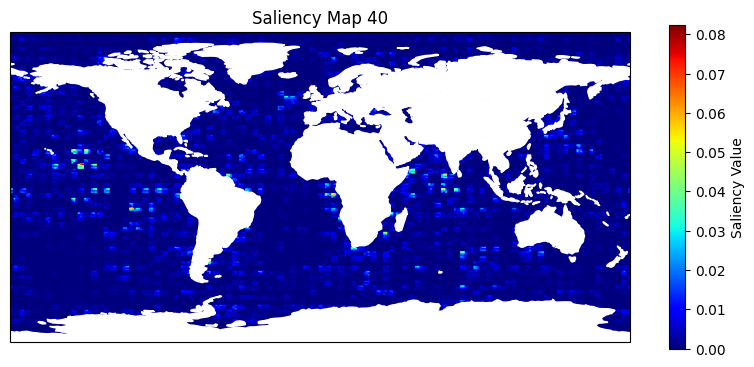

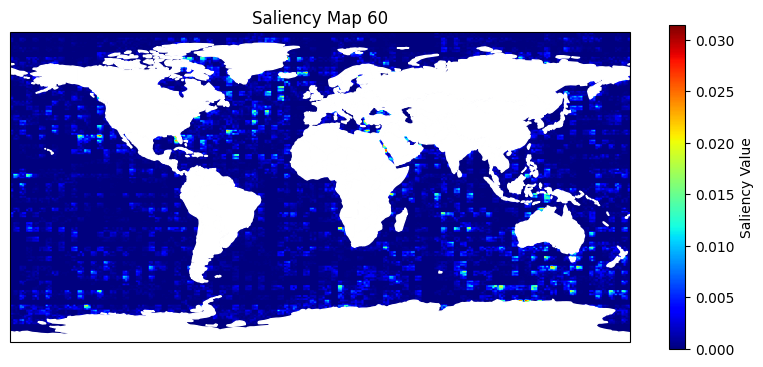

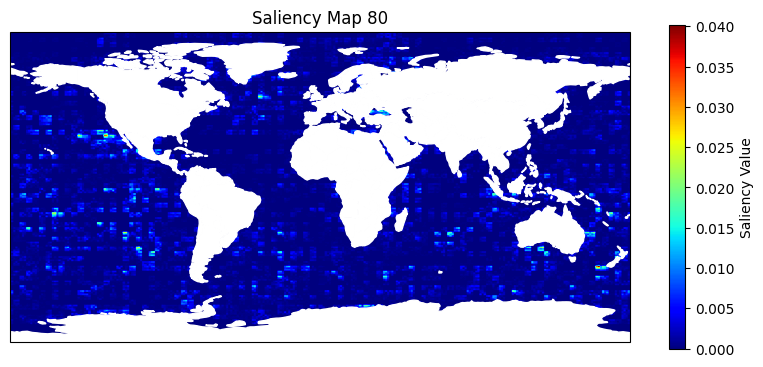

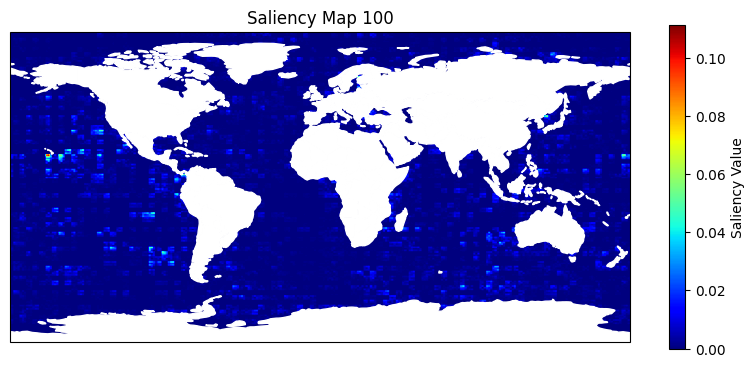

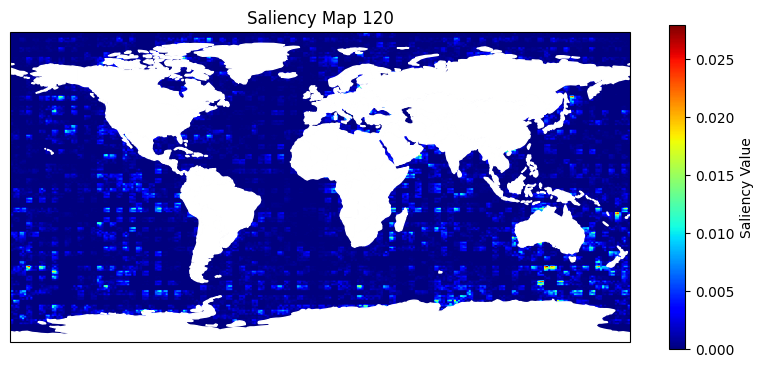

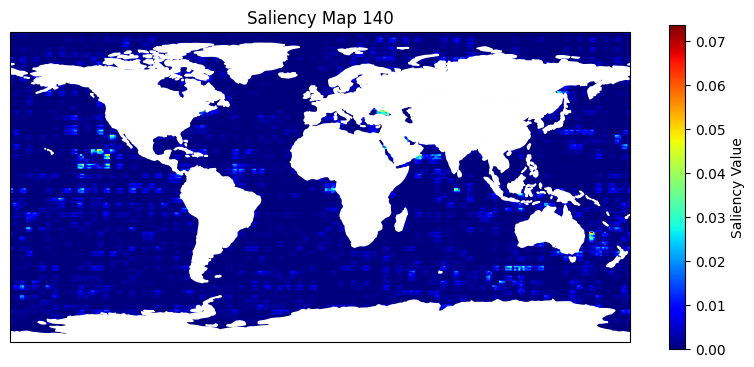

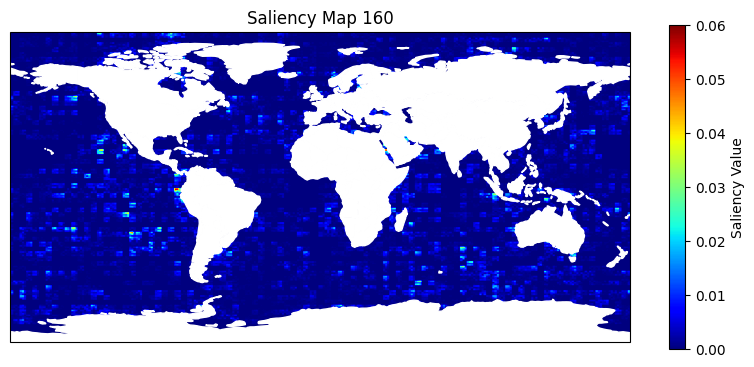

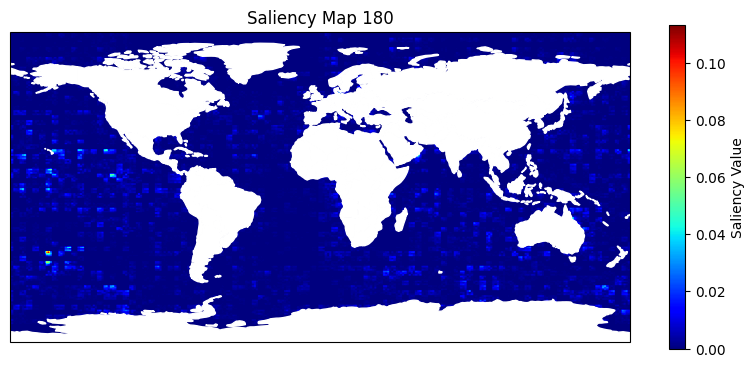

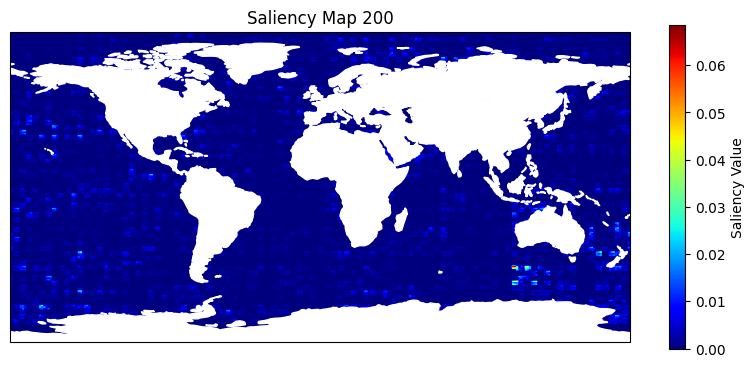

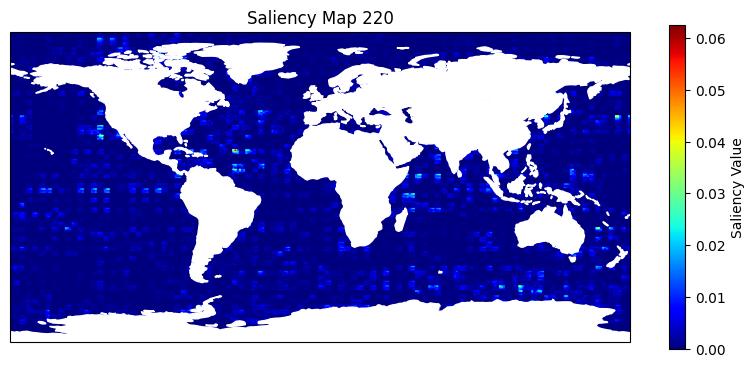

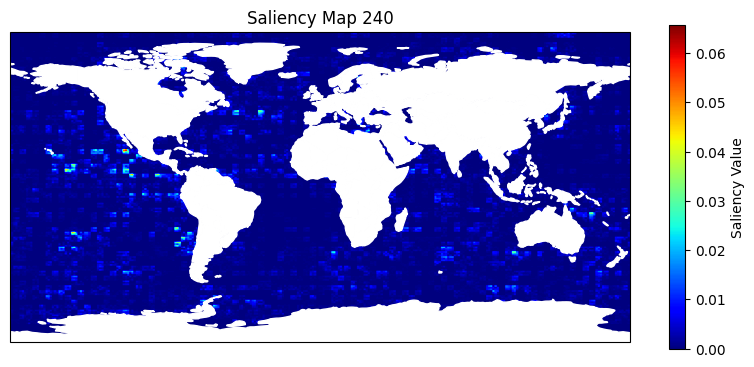

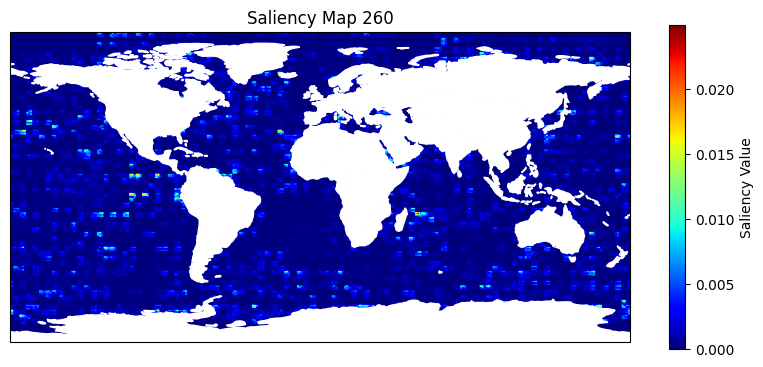

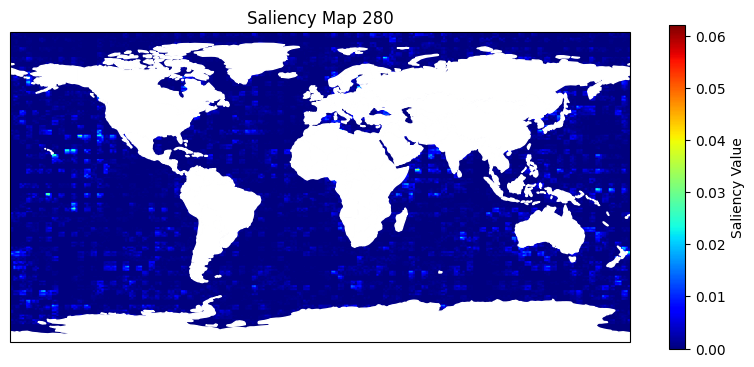

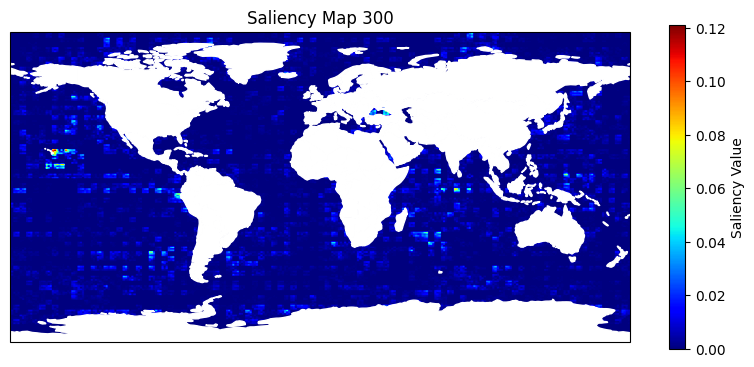

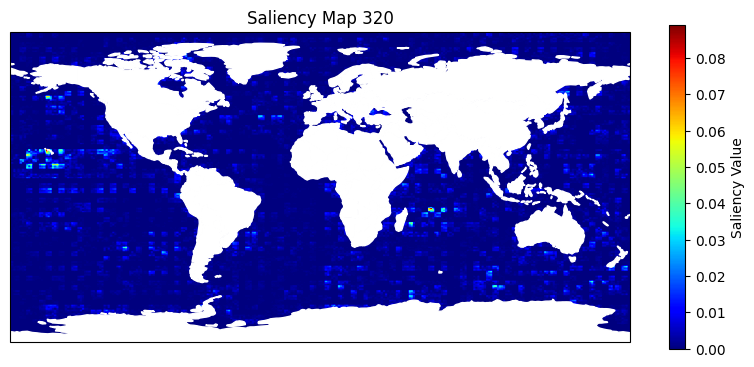

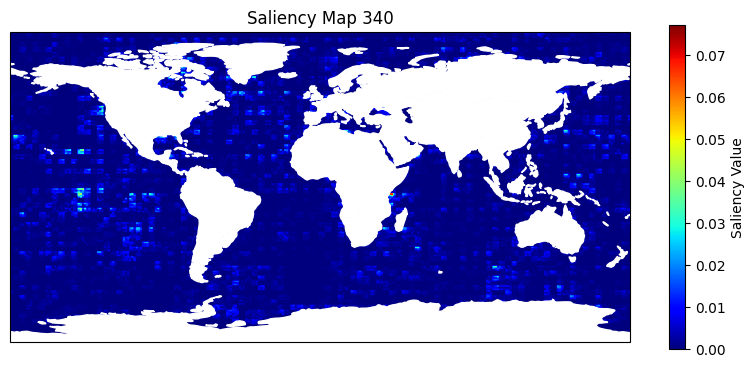

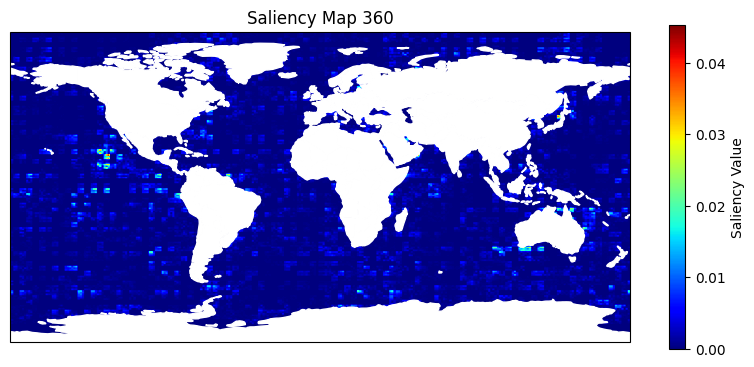

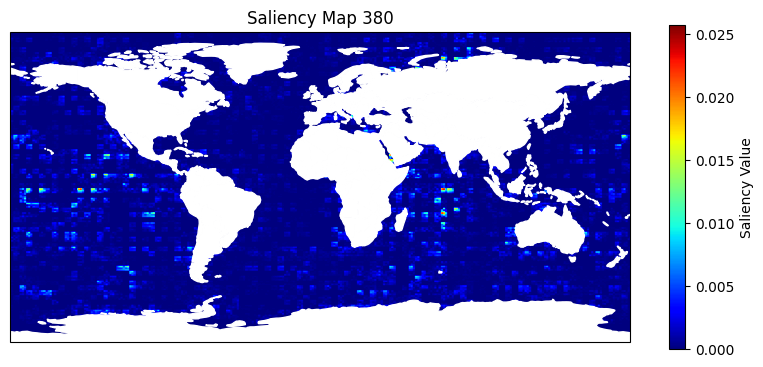

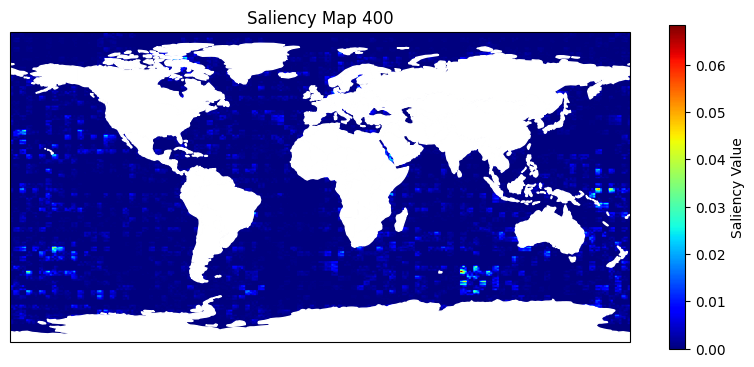

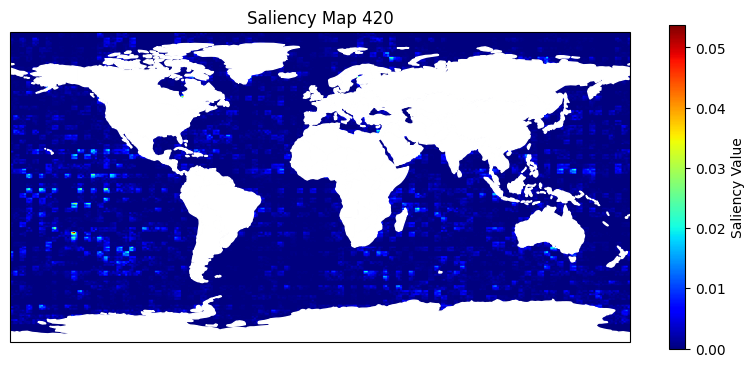

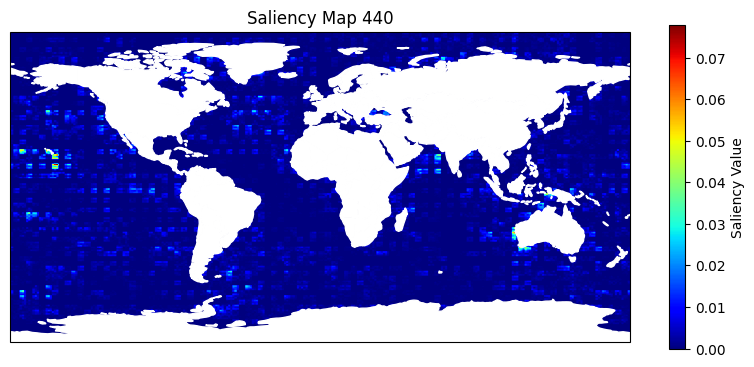

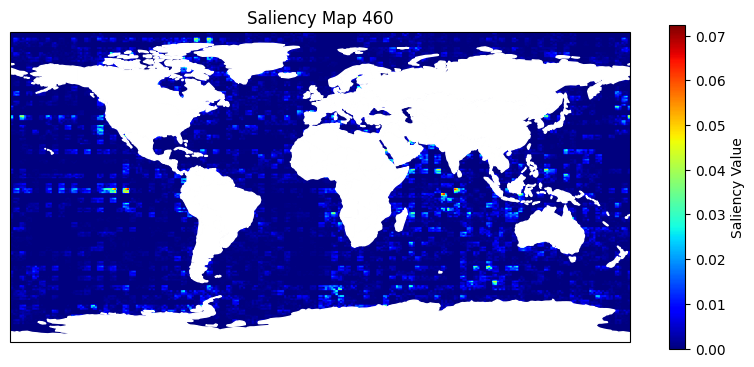

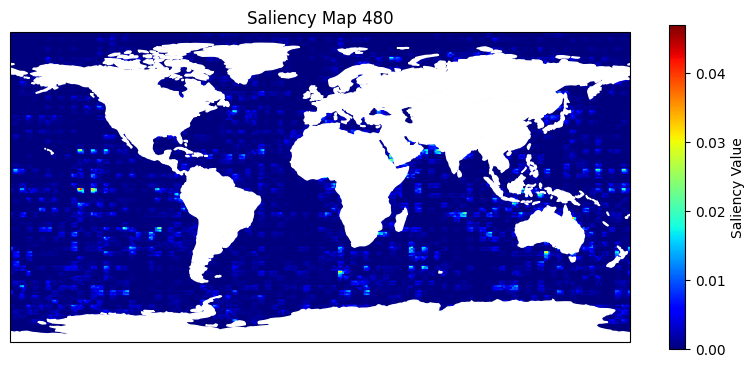

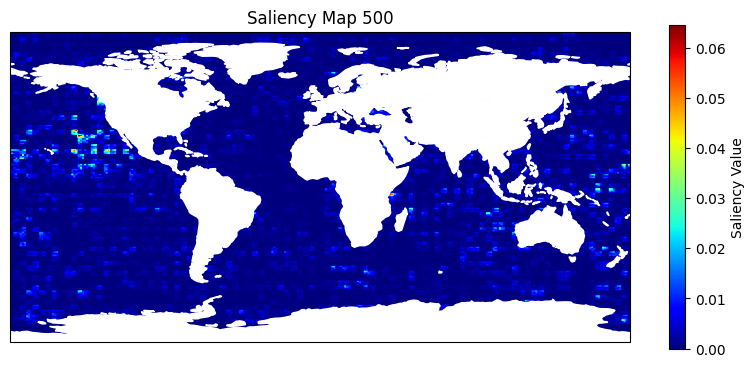

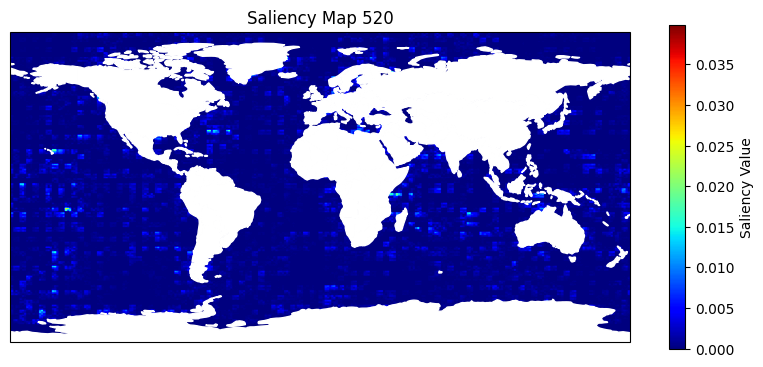

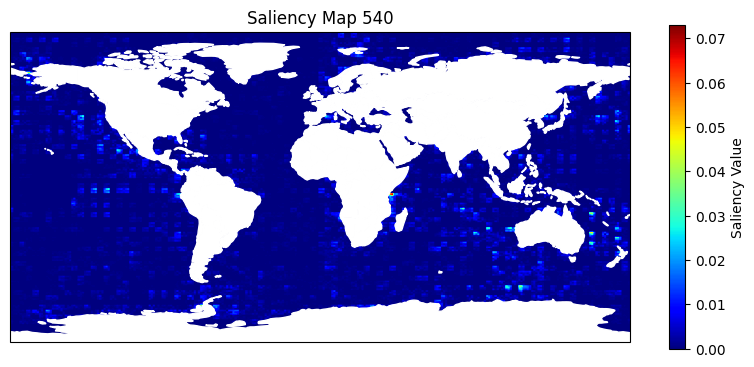

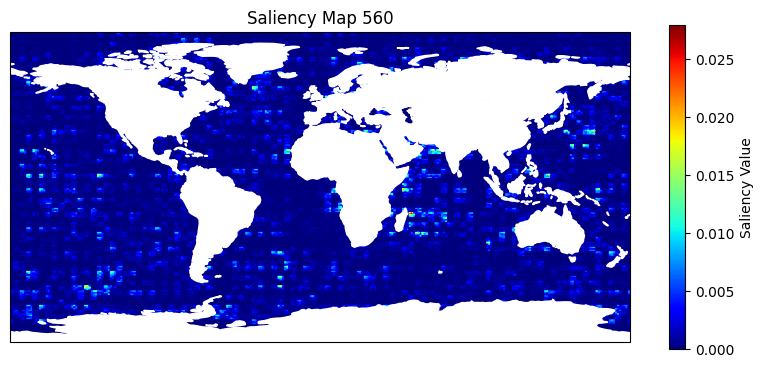

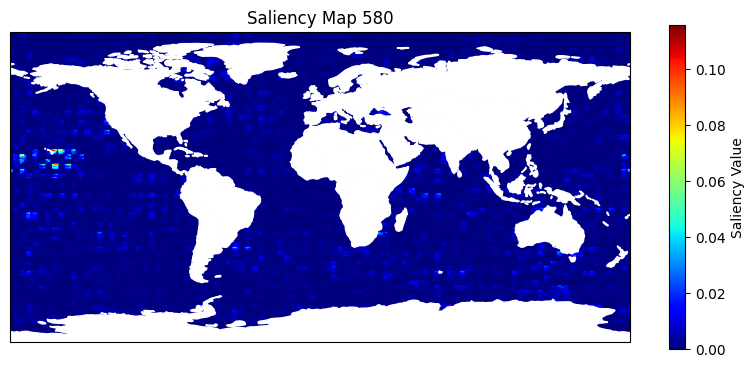

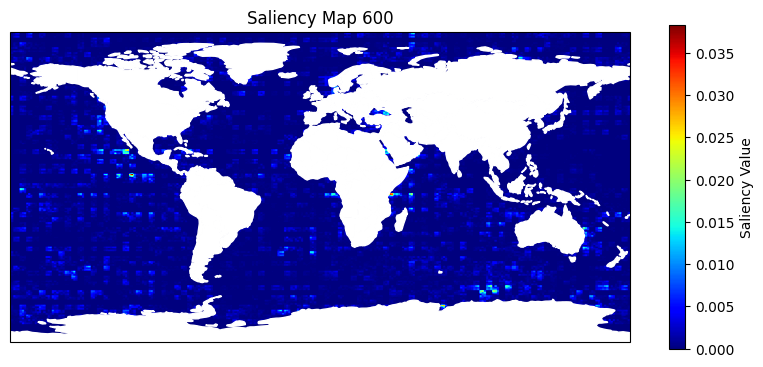

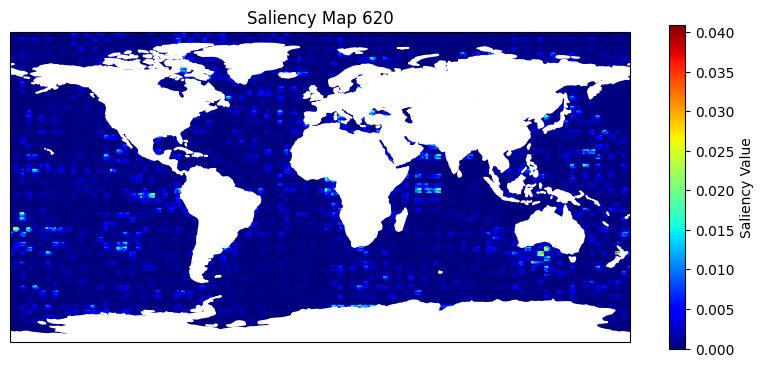

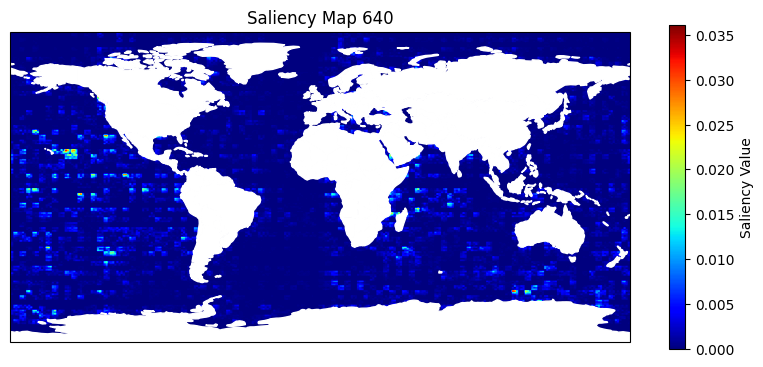

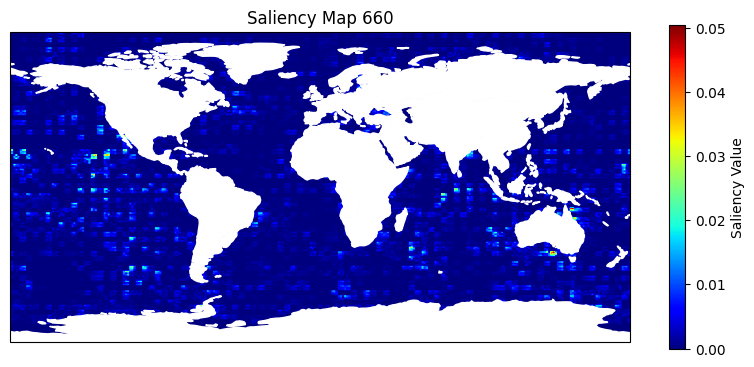

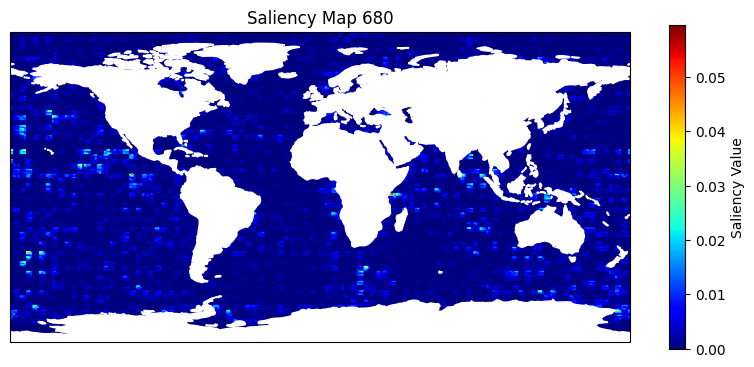

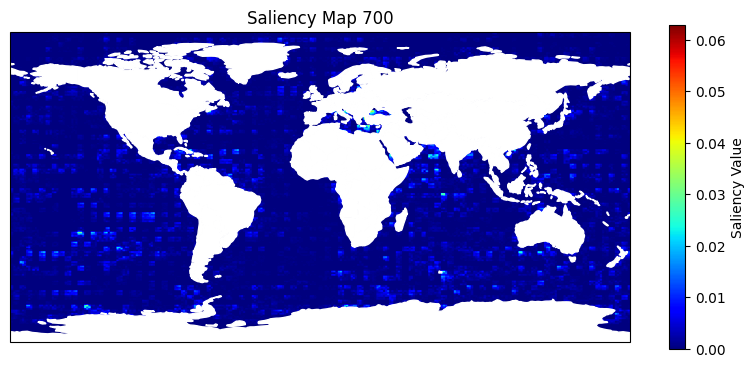

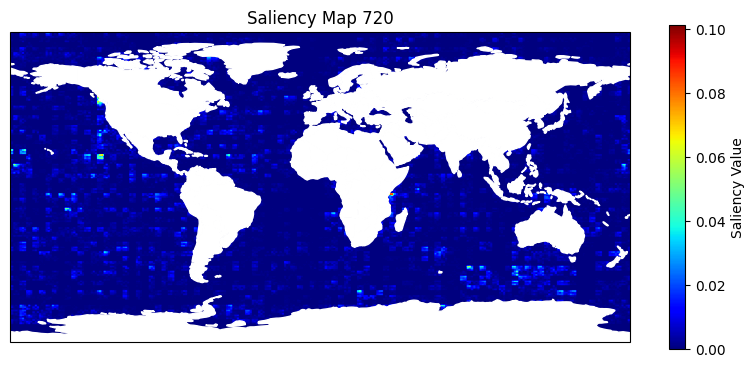

In [101]:
def generate_saliency_map(input_data, model_best_weights, longitude, latitude, device, title):
    # Create a Saliency object for your model
    saliency = Saliency(model_best_weights)

    # Compute the saliency map
    saliency_map = saliency.attribute(input_data.to(device))

    # Convert saliency map to NumPy array
    saliency_map_np = saliency_map.cpu().detach().numpy()

    saliency_map_np = np.flipud(saliency_map_np.squeeze())

    # Resize the saliency map to match latitude and longitude dimensions
    saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

    # Add cyclic point to the data
    saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

    # Plot the saliency map
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Overlay the saliency map
    img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

    # Add country outlines and fill them in white
    shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

    cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label('Saliency Value')

    plt.title(f'Saliency Map {title}')
    plt.show()

# Example usage

longitude = ds2['lon'].values
latitude = ds2['lat'].values

for i in range(0,740,20):
    input_data = X_test[i].unsqueeze(0).unsqueeze(0)
    input_data.requires_grad_(True)
    generate_saliency_map(input_data, model_best_weights, longitude, latitude, device, i)

# Testing on Real World Data

In [57]:
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 74, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 592B 0 365 730 1096 1461 ... 25567 25933 26298 26663
Data variables:
    SST      (time, lat, lon) float64 33MB ...

In [59]:
PRECT_real

Unnamed: 0  year region     PRECT
0             3  1950  North -1.252478
1             4  1951  North  6.405958
2             5  1952  North  0.244133
3             6  1953  North -1.394033
4             7  1954  North -9.740346
..          ...   ...    ...       ...
211          70  2017  South -3.404232
212          71  2018  South  3.063811
213          72  2019  South  0.466426
214          73  2020  South -3.871161
215          74  2021  South -2.409134

[216 rows x 4 columns]

In [85]:
PRECT_real = pd.read_csv('real_world_prect.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.head()

PRECT
year region          
1950 North  -1.252478
1951 North   6.405958
1952 North   0.244133
1953 North  -1.394033
1954 North  -9.740346

In [111]:
PRECT_real.iloc[72:144]

PRECT
year region           
1950 Central -0.238446
1951 Central  5.686935
1952 Central -2.287565
1953 Central -1.109147
1954 Central -2.598390
...                ...
2017 Central -1.968045
2018 Central  5.493383
2019 Central -2.887452
2020 Central -3.886926
2021 Central -3.686251

[72 rows x 1 columns]

In [110]:
216/3

72.0

In [112]:
y= PRECT_real.to_numpy()
y.shape

(216, 1)

In [113]:
y = y[72:144]
y.shape

(72, 1)

In [114]:
len(y)

72

In [115]:
X = ds3['SST'].to_numpy()
X.shape

(74, 192, 288)

In [117]:
X = X[:72, :, :]
X.shape

(72, 192, 288)

In [118]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [119]:
BATCH_SIZE = 32

X = from_numpy(X).float()
y = from_numpy(y).float()

X = X.view(-1, 192, 288)
y = y.view(-1, 1)

dataset_real = TensorDataset(X, y)
dataloader_real = DataLoader(dataset_real, batch_size=BATCH_SIZE, shuffle=False)


In [120]:
X.shape

torch.Size([72, 192, 288])

In [121]:
y.shape

torch.Size([72, 1])

In [124]:
actual_values = np.array(y.squeeze(1))

# Set the model to evaluation mode
model_best_weights.eval()

predicted_values = model_best_weights(X.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

#torch.save(model_best_weights.state_dict(), 'avg_pool_no_bias_best_weights_1472.pth')

R-squared: 0.08917421102523804


In [125]:
test_valid_loop(dataloader_real, model_best_weights, loss_fn, valid = False)

Test Loss: 15.732639 



In [126]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(72):
    pred_dict[i] = actual_values[i]
    pred_dict2[i] = predicted_values[i]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


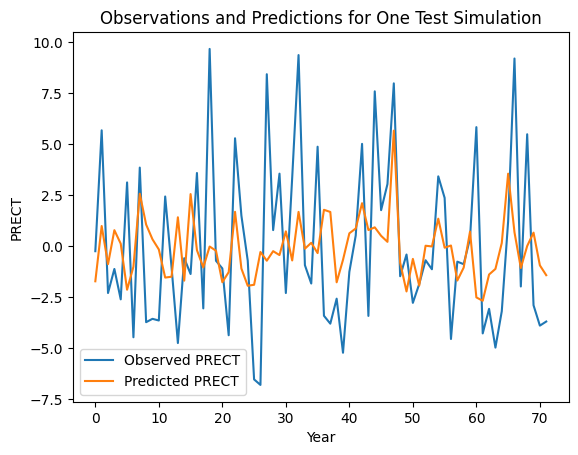

In [127]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()